In [1]:
!pip install datasets

/bin/bash: /home2/bagler/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
from datasets import load_from_disk
dataset = load_from_disk('data')

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dot, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-04-08 22:25:59.750389: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-08 22:25:59.794000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 22:26:00.441577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [6]:
train_data = dataset['train'][:10000]
val_data = dataset['validation']
test_data = dataset['test']

In [7]:
from tqdm.auto import tqdm

# Get the English sentences from the training split
english_sentences = [train_data['translation'][i]['en'] for i in tqdm(range(len(train_data['translation'])))]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
from tqdm.auto import tqdm

# Get the German sentences from the training split
german_sentences = [train_data['translation'][i]['de'] for i in tqdm(range(len(train_data['translation'])))]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
from tqdm.auto import tqdm

# Get the German sentences from the training split
german_sentences_valid = [dataset['validation'][i]['translation']['de'] for i in tqdm(range(len(dataset['validation'])))]

  0%|          | 0/2169 [00:00<?, ?it/s]

In [10]:
from tqdm.auto import tqdm

# Get the English sentences from the training split
english_sentences_valid = [dataset['validation'][i]['translation']['en'] for i in tqdm(range(len(dataset['validation'])))]

  0%|          | 0/2169 [00:00<?, ?it/s]

In [11]:
from tqdm.auto import tqdm

# Get the English sentences from the training split
english_sentences_test = [dataset['test'][i]['translation']['en'] for i in tqdm(range(len(dataset['test'])))]

  0%|          | 0/2999 [00:00<?, ?it/s]

In [12]:
from tqdm.auto import tqdm

# Get the German sentences from the training split
german_sentences_test = [dataset['test'][i]['translation']['de'] for i in tqdm(range(len(dataset['test'])))]

  0%|          | 0/2999 [00:00<?, ?it/s]

In [13]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [14]:
def preprocess_text(text):
    # Remove punctuation using the string library
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lowercase the text
    text = text.lower()
    return text


eng_sentences = []
ger_sentences = []
eng_sentences_val = []
ger_sentences_val = []
eng_sentences_test = []
ger_sentences_test = []


for s1, s2 in zip(english_sentences, german_sentences):
  eng_sentences.append(preprocess_text(s1))
  ger_sentences.append(preprocess_text(s2))


for p1, p2 in zip(english_sentences_valid, german_sentences_valid):
  eng_sentences_val.append(preprocess_text(s1))
  ger_sentences_val.append(preprocess_text(s2))


for p1, p2 in zip(english_sentences_test, german_sentences_test):
  eng_sentences_test.append(preprocess_text(s1))
  ger_sentences_test.append(preprocess_text(s2))


In [15]:
#build tokenizer for both eng, deu sentences

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

eng_tokenizer = tokenization(eng_sentences)
eng_vocab_size = len(eng_tokenizer.word_index) + 1


eng_tokenizer_val = tokenization(eng_sentences_val)
eng_vocab_size_val = len(eng_tokenizer_val.word_index) + 1

eng_tokenizer_test = tokenization(eng_sentences_test)
eng_vocab_size_test = len(eng_tokenizer_test.word_index) + 1


deu_tokenizer = tokenization(ger_sentences)
deu_vocab_size = len(deu_tokenizer.word_index) + 1


deu_tokenizer_val = tokenization(ger_sentences_val)
deu_vocab_size_val = len(deu_tokenizer_val.word_index) + 1

deu_tokenizer_test = tokenization(ger_sentences_test)
deu_vocab_size_test = len(deu_tokenizer_val.word_index) + 1


print('English Vocabulary Size: %d' % eng_vocab_size)
print('Deutch Vocabulary Size: %d' % deu_vocab_size)
print('English Vocabulary Size (Validation): %d' % eng_vocab_size_val)
print('Deutch Vocabulary Size (Validation): %d' % deu_vocab_size_val)
print(eng_tokenizer_val)

English Vocabulary Size: 11119
Deutch Vocabulary Size: 19507
English Vocabulary Size (Validation): 26
Deutch Vocabulary Size (Validation): 19


In [16]:
#encode and pad sequences

def encode_sequences(tokenizer, length, lines):
    #integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    #pad sequences with 0 values
    seq = pad_sequences(seq, maxlen = length, padding = 'post')
    return seq

In [17]:
#prepare training data
trainX = encode_sequences(eng_tokenizer, 32, eng_sentences)
trainY = encode_sequences(deu_tokenizer, 32, ger_sentences)

In [18]:
# prepare validation data
testX = encode_sequences(eng_tokenizer_val, 32, eng_sentences_val)
testY = encode_sequences(deu_tokenizer_val, 32, ger_sentences_val)

In [19]:
# prepare validation data
testX_new = encode_sequences(eng_tokenizer_val, 32, eng_sentences_test)
testY_new = encode_sequences(deu_tokenizer_val, 32, ger_sentences_test)

In [20]:
import nltk 
# nltk.download('punkt')

In [21]:
#Reference : https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/

import string
import re
from unicodedata import normalize
from numpy import array

# function to clean a list of sentences
def clean_lines(sentences):
	#initialising a empty list
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for sentence in sentences:
    # normalize unicode characters
		sentence = normalize('NFD', sentence).encode('ascii', 'ignore')
		sentence = sentence.decode('UTF-8')
		# tokenize on white space
		sentence = sentence.split()
		# convert to lowercase
		sentence = [word.lower() for word in sentence]
		# remove punctuation from each token
		sentence = [word.translate(table) for word in sentence]
		# remove non-printable chars form each token
		sentence = [re_print.sub('', w) for w in sentence]
		# remove tokens with numbers in them
		sentence = [word for word in sentence if word.isalpha()]
		cleaned.append(' '.join(sentence))
	return cleaned

In [22]:
#cleaned english/source sentences
eng_sentences = clean_lines(english_sentences)
eng_sentences  = [ 'bof_ ' + line + ' _eos' for line in eng_sentences]
print(len(eng_sentences))
eng_sentences[-5:]

10000


['bof_ this policy would have important economic consequences for the fishing industry in brittany in that catches could be unloaded at irish advance bases in order to then be transported to the breton agrifoodstuffs industry _eos',
 'bof_ the integration of the maritime border into strand a would finally allow the western periphery to be recognised as a unique and important economic area which is confronted by the continentalisation of the european union _eos',
 'bof_ this would show respect for these peripheral areas which are rather concerned about enlargement to the east _eos',
 'bof_ the maritime world has great potential _eos',
 'bof_ we therefore must not leave it out of innovative and pilot community programmes which will allow the new geographical and economic map of europe to be defined _eos']

In [23]:
#cleaned english/source sentences
eng_sentences_test = clean_lines(english_sentences_test)
eng_sentences_test  = [ 'bof_ ' + line + ' _eos' for line in eng_sentences_test]
print(len(eng_sentences_test))
eng_sentences_test[-5:]

2999


['bof_ mercury is released into the environment primarily through the burning of coal _eos',
 'bof_ german coal plants according to written information from the german ministry of the environment to green bundestag member annalena baerbock discharge more than six tonnes of mercury per year two thirds of the total amount emitted in germany _eos',
 'bof_ the concentration of mercury in fish for example in the elbe rhine and danube is extensively exceeded on a longterm basis the spiegel newspaper quoted from the paper in march _eos',
 'bof_ in the past year europewide alerts on mercury in fish rated among the most frequently reported health risks in the eu warning system rasff _eos',
 'bof_ foodwatch is calling for consumers to protest against the eu plans under wwwquecksilberaktionfoodwatchde _eos']

In [24]:
eng_sentences_valid = clean_lines(english_sentences_valid)
eng_sentences_valid  = [ 'bof_ ' + line + ' _eos' for line in eng_sentences_valid]
print(len(eng_sentences_valid))
eng_sentences_valid[-5:]

2169


['bof_ the walkers started at am _eos',
 'bof_ then it was the turn of the cyclists and runners who began at am _eos',
 'bof_ five minutes later the first mountainbikers set off _eos',
 'bof_ bent hansen chairman of the association cycling on the grosser feldberg gave the starting orders and wished those taking part an enjoyable trip _eos',
 'bof_ next year he hopes to have safety barriers on the course for the benefit of those taking part on the feldberg _eos']

In [25]:
#cleaned german/target sentenc
german_sentences = clean_lines(german_sentences)

#adding 'bof_' and '_eos' tokens at the start and end of the sentences
# I didn't use <bof> and <eos> tokens here as nltk tokenizer was splitting <bof> as <,bof,>
german_sentences  = [ 'bof_ ' + line + ' _eos' for line in german_sentences]

print(len(german_sentences))
german_sentences[-5:]

10000


['bof_ diese politik hatte gunstige auswirkungen auf die bretonische fischerei da diese dann ihre fangmengen in vorgeschobenen irischen stutzpunkten anlanden und sie anschlieend in die bretonische ernahrungswirtschaft zuruckfuhren konnte _eos',
 'bof_ die einbeziehung der seegrenze in die ausrichtung a wurde es endlich ermoglichen als gegengewicht zur zunehmenden festlandslastigkeit der europaischen union an deren westlichem rand eine einheitliche wirtschaftszone zu schaffen _eos',
 'bof_ dies wurde auch eine aufwertung dieser regionen in randlage bedeuten die angesichts der erweiterung nach osten etwas beunruhigt sind _eos',
 'bof_ die kustenregionen mit ihrer seewirtschaft weisen ein groes entwicklungspotential auf _eos',
 'bof_ wir sollten sie daher bei innovativen und wegweisenden gemeinschaftsprogrammen die zur geographischen und wirtschaftlichen umgestaltung europas beitragen nicht ausschlieen _eos']

In [26]:
#cleaned german/target sentenc
german_sentences_valid = clean_lines(german_sentences_valid)

#adding 'bof_' and '_eos' tokens at the start and end of the sentences
# I didn't use <bof> and <eos> tokens here as nltk tokenizer was splitting <bof> as <,bof,>
german_sentences_valid  = [ 'bof_ ' + line + ' _eos' for line in german_sentences_valid]

print(len(german_sentences_valid))
german_sentences_valid[-5:]

2169


['bof_ die wanderer zuerst um uhr _eos',
 'bof_ es folgten die ersten radfahrer und laufer um uhr _eos',
 'bof_ funf minuten spater legten die ersten mountainbiker los _eos',
 'bof_ bent hansen vorsitzender des vereins radeln auf den groen feldberg gab die startkommandos und wunschte den teilnehmern einen schonen ausflug _eos',
 'bof_ fur nachstes jahr hoffe er dass es gelingt die strecke zum feldberg hinauf zur sicherheit der teilnehmer zu sperren _eos']

In [27]:
#cleaned german/target sentenc
german_sentences_test = clean_lines(german_sentences_test)

#adding 'bof_' and '_eos' tokens at the start and end of the sentences
# I didn't use <bof> and <eos> tokens here as nltk tokenizer was splitting <bof> as <,bof,>
german_sentences_test  = [ 'bof_ ' + line + ' _eos' for line in german_sentences_test]

print(len(german_sentences_test))
german_sentences_test[-5:]

2999


['bof_ quecksilber gelangt vor allem durch die kohleverbrennung in die umwelt _eos',
 'bof_ die deutschen kohlekraftwerke stoen laut einer schriftlichen auskunft des bundesumweltministeriums an die grunenbundestagsabgeordnete annalena baerbock mehr als sechs tonnen quecksilber im jahr aus zwei drittel der in deutschland emittierten gesamtmenge _eos',
 'bof_ die konzentration von quecksilber in fischen etwa in elbe rhein und donau sei dauerhaft und flachendeckend uberschritten hatte der spiegel im marz aus dem papier zitiert _eos',
 'bof_ im vergangenen jahr zahlten europaweite warnungen vor quecksilber in fisch bereits zu den haufigsten gemeldeten gesundheitsrisiken im euwarnsystem rasff _eos',
 'bof_ foodwatch ruft verbraucher zum protest gegen die plane der eu auf unter wwwquecksilberaktionfoodwatchde _eos']

In [28]:
def get_vocabulary(sentences):
  vocab=set()
  max_length = 0
  #Iterating through each sentence in the sentences list
  for line in sentences:
    #word tokenising the sentence
    words = nltk.word_tokenize(line)
    # updating max length is larger sentence is found
    if len(words)> max_length:
      max_length = len(words)
    #for each word in the tokenized words, if it's not in the vocabulary, add it to the vocabulary
    for word in words:
      if word not in vocab:
          vocab.add(word)
  #returning a sorted list of vocabulary and maximum length
  return sorted(list(vocab)),max_length

In [29]:
#English vocabulary(sorted list of all the words in the corpus), max sentence length for english
eng_vocabulary,max_eng_sent_length = get_vocabulary(eng_sentences)
print("Vocabulary length: ",len(eng_vocabulary))
max_eng_sent_length

Vocabulary length:  10712


163

In [30]:
#German vocabulary(sorted list of all the words in the corpus), max sentence length for german
german_vocabulary,max_german_sent_length = get_vocabulary(german_sentences)
print(len(german_vocabulary))
max_german_sent_length

18987


154

In [31]:
# Total number of unique source and target language tokens
tot_eng_tokens = len(eng_vocabulary)
tot_german_tokens = len(german_vocabulary)

In [32]:
print('Total number of examples: ', len(eng_sentences))
print('Total number of unique source(English) language tokens: ', tot_eng_tokens)
print('Total number of unique target(German) language tokens: ', tot_german_tokens)
print('Maximum sequence length of source(English) language: ', max_eng_sent_length)
print('Maximum sequence length of target(German) language: ', max_german_sent_length)
#print("Source Vocabulary",eng_vocabulary)
#print("Target Vocabulary",german_vocabulary)

Total number of examples:  10000
Total number of unique source(English) language tokens:  10712
Total number of unique target(German) language tokens:  18987
Maximum sequence length of source(English) language:  163
Maximum sequence length of target(German) language:  154


In [33]:
import numpy as np

In [34]:
# assign an integer value to each unique token in the voacubulary
input_token_index = dict([(word,i) for i, word in enumerate(eng_vocabulary)])
target_token_index= dict([(word,i) for i, word in enumerate(german_vocabulary)])

In [35]:
UNK_TOKEN = "<unk>"

In [36]:
# add the <unk> token to the dictionaries
input_token_index[UNK_TOKEN] = 0
target_token_index[UNK_TOKEN] = 0

In [37]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [38]:
# !unnzip glove.6B.zip

In [39]:
# Reference : https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

embeddings_index = {}
f = open('./glove.6B/glove.6B.50d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [40]:
#construct the embedding matrix using the embedding index dictionary and the word index created previously
max_words = tot_eng_tokens - 1
embedding_matrix = np.zeros((tot_eng_tokens, 50))
for i, word in enumerate(list(eng_vocabulary)):
    if i > max_words:
        continue
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [41]:
print(len(embedding_matrix))

10712


In [42]:
print(len(trainX))
print(trainX.shape)

10000
(10000, 32)


In [43]:
import numpy as np
# import nltk
# nltk.download('punkt')

In [44]:
#  initializing placeholders for input and output data
enc_input_data=np.zeros((len(trainX),max_eng_sent_length),dtype='float32')
dec_input_data=np.zeros((len(trainY), max_german_sent_length),dtype='float32')
dec_target_data=np.zeros((len(trainY), max_german_sent_length, tot_german_tokens),dtype='float32')

In [45]:
#  initializing placeholders for input and output data
enc_input_data_test=np.zeros((len(testX),max_eng_sent_length),dtype='float32')
dec_input_data_test=np.zeros((len(testY), max_german_sent_length),dtype='float32')
dec_target_data_test=np.zeros((len(testY), max_german_sent_length, tot_german_tokens),dtype='float32')

In [46]:
#  initializing placeholders for input and output data
enc_input_data_test_new=np.zeros((len(testX_new),max_eng_sent_length),dtype='float32')
dec_input_data_test_new=np.zeros((len(testY_new), max_german_sent_length),dtype='float32')
dec_target_data_test_new=np.zeros((len(testY_new), max_german_sent_length, tot_german_tokens),dtype='float32')

In [47]:
print(enc_input_data)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [48]:
print(enc_input_data_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [49]:
# generating the data for the above created placeholders 
for i, (input_txt, target_txt) in enumerate(zip(eng_sentences,german_sentences)):
    for t, word in enumerate(nltk.word_tokenize(input_txt)):
        enc_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(nltk.word_tokenize(target_txt)):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        dec_input_data[i, t] = target_token_index[word]
        if t > 0:
            #Due to the addition of ‘<bof>' to the german sentences at the start, the target data will be shifted by one.
            dec_target_data[i, t - 1, target_token_index[word]] = 1.

In [50]:
UNK_TOKEN = "<unk>"

for i, (input_txt, target_txt) in enumerate(zip(eng_sentences_valid, german_sentences_valid)):
    for t, word in enumerate(nltk.word_tokenize(input_txt)):
        enc_input_data_test[i, t] = input_token_index.get(word, input_token_index[UNK_TOKEN])
    for t, word in enumerate(nltk.word_tokenize(target_txt)):
        if t > 0:
            dec_input_data_test[i, t - 1] = target_token_index.get(word, target_token_index[UNK_TOKEN])
            if word in target_token_index:
                dec_target_data_test[i, t - 1, target_token_index[word]] = 1.


In [51]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import tensorflow as tf

In [60]:
from keras.layers import Activation, dot, concatenate
from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense

# encoder input layer of attention model
attention_encoder_input = Input(shape=(max_eng_sent_length,))
#embedding layer of the encoder using Glove embeddings
attention_encoder = Embedding(tot_eng_tokens, 50 , weights= [embedding_matrix], trainable=True)(attention_encoder_input) 
# LSTM layer of the encoder
attention_encoder = LSTM(256, return_sequences=True, unroll=True)(attention_encoder) 
# The encoder's last word is sent into the decoder's input.
attention_encoder_last = attention_encoder[:,-1,:]  

#decoder input layer of attention model
attention_decoder_input = Input(shape=(max_german_sent_length,))
# embedding layer of decoder created using Keras Embedding layer
attention_decoder = Embedding(tot_german_tokens, 50)(attention_decoder_input)
# LSTM layer of the decoder
attention_decoder = LSTM(256, return_sequences=True, unroll=True)(attention_decoder, initial_state=[attention_encoder_last, attention_encoder_last])

# weights of the encoder and decoder as a dot product to get attention
attention = dot([attention_decoder, attention_encoder], axes=[2, 2])
# The softmax function  gives the probability distribution which can used as attention weights
attention = Activation('sigmoid', name='attention')(attention)
# pre attention weight and encoder as a dot product to give context
context = dot([attention, attention_encoder], axes=[2,1])
# context concatenated with decoder
decoder_combined_contxt = concatenate([context, attention_decoder])

# Time distributed layer with tanh activation
output = TimeDistributed(Dense(64, activation="relu"))(decoder_combined_contxt)
#Time distributed softmax function to calculate the probability distirbution of the output words sequence
output = TimeDistributed(Dense(tot_german_tokens, activation="softmax"))(output)

2023-04-08 22:26:23.638493: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-08 22:26:23.638556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: cb-gpu-server
2023-04-08 22:26:23.638568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: cb-gpu-server
2023-04-08 22:26:23.638820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 515.65.1
2023-04-08 22:26:23.638861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 515.65.1
2023-04-08 22:26:23.638871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 515.65.1


In [61]:
#defining the model
attention_model = Model(inputs =[attention_encoder_input, attention_decoder_input], outputs =[output])
attention_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
attention_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 163)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 163, 50)      535600      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 154)]        0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 163, 256)     314368      ['embedding[0][0]']              
                                                                                              

In [62]:
tf.config.list_physical_devices('GPU')

[]

In [63]:
# Training the model
attention_model.fit([enc_input_data, dec_input_data], dec_target_data,
          batch_size=72,
          epochs=5,
          validation_data=([enc_input_data_test, dec_input_data_test], dec_target_data_test))

Epoch 1/5
139/139 [==============================] - 327s 2s/step - loss: 1.1375 - val_loss: 0.6460
Epoch 2/5
139/139 [==============================] - 275s 2s/step - loss: 1.0872 - val_loss: 0.6347
Epoch 3/5
139/139 [==============================] - 274s 2s/step - loss: 1.0722 - val_loss: 0.6333
Epoch 4/5
139/139 [==============================] - 275s 2s/step - loss: 1.0545 - val_loss: 0.6250
Epoch 5/5
139/139 [==============================] - 261s 2s/step - loss: 1.0346 - val_loss: 0.6267


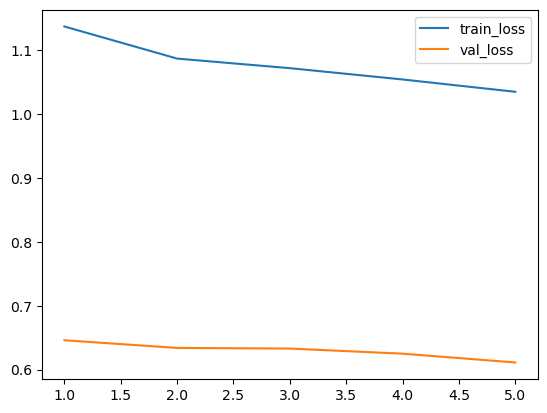

In [65]:
train_loss = [ 1.1375, 1.0872, 1.0722, 1.0545, 1.0352 ]
val_loss = [0.646, 0.634, 0.633, 0.625, 0.6112 ]
plt.plot(range(1,6), train_loss, label = 'train_loss' )
plt.plot(range(1,6), val_loss, label = 'val_loss' )
plt.legend()
plt.show()

In [66]:
attention_model.save('saved_model/global')

2023-04-08 22:59:08.497891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,512]
	 [[{{node inputs}}]]
2023-04-08 22:59:08.504163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,512]
	 [[{{node inputs}}]]
2023-04-08 22:59:08.537108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,64]
	 [[{{node inputs}}]]
2023-04-08 

INFO:tensorflow:Assets written to: saved_model/global/assets


INFO:tensorflow:Assets written to: saved_model/global/assets


In [ ]:
# attention_model = tf.keras.models.load_model('saved_model/global')

In [67]:
# reverse-lookup token index to turn sequences back to words
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [68]:
#function to translate input sequence to target language using attention
def translation_attention(input_seq):
    translated_sentence = ''
    enc_input = input_seq.reshape(1,max_eng_sent_length)
    #initialising numpy matrix of required dimensions
    dec_input = np.zeros(shape=(len(enc_input), max_german_sent_length))
    #bof_ is the first entry of the decoder input
    dec_input[:,0] = target_token_index['bof_']
    for i in range(1, max_german_sent_length):
        output = attention_model.predict([enc_input, dec_input]).argmax(axis=2)
        dec_input[:,i] = output[:,i]
    for k in dec_input[0]:
        #condition to break out of the loop(i.e if we see the end(_eos) token)    
        if (reverse_target_char_index[k] == '_eos'):
            translated_sentence += ' '+reverse_target_char_index[k]
            break
        translated_sentence += ' '+reverse_target_char_index[k]
    return translated_sentence

In [69]:
#Displaying few translations from the training set
for i in range(2):
    input_seq = enc_input_data[i: i+ 1]
    translated_sentence = translation_attention(input_seq)
    print('\n')
    print('Input sentence:', eng_sentences[i: i + 1])
    print('Translated sentence:', translated_sentence)

1/1 [==============================] - 0s 54ms/step


Input sentence: ['bof_ resumption of the session _eos']
Translated sentence:  bof_ die <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <

In [70]:
#Translating the sentences in test data set
original_sequence_att, predicted_sequence_att = list(), list()
for i in range(30):
    print(i)
    input_seq = enc_input_data_test_new[i: i + 1]
    decoded_sent = translation_attention(input_seq)
    predicted_sequence_att.append(decoded_sent)
    original_sequence_att.append(german_sentences_test[i])

0
1/1 [==============================] - 0s 42ms/step
1
1/1 [==============================] - 0s 33ms/step
2
1/1 [==============================] - 0s 60ms/step
3
1/1 [==============================] - 0s 54ms/step
4
1/1 [==============================] - 0s 58ms/step
5
1/1 [==============================] - 0s 61ms/step
6
1/1 [==============================] - 0s 33ms/step
7
1/1 [==============================] - 0s 57ms/step
8
1/1 [==============================] - 0s 60ms/step
9
1/1 [==============================] - 0s 33ms/step
10
1/1 [==============================] - 0s 56ms/step
11
1/1 [==============================] - 0s 59ms/step
12
1/1 [==============================] - 0s 53ms/step
13
1/1 [==============================] - 0s 54ms/step
14
1/1 [==============================] - 0s 54ms/step
15
1/1 [==============================] - 0s 52ms/step
16
1/1 [==============================] - 0s 33ms/step
17
1/1 [==============================] - 0s 60ms/step
18
1/1 [============

In [71]:
original_sequence_att[0]

'bof_ obama empfangt netanyahu _eos'

In [72]:
# Copyright 2020 The HuggingFace Datasets Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" ROUGE metric from Google Research github repo. """

# The dependencies in https://github.com/google-research/google-research/blob/master/rouge/requirements.txt
import absl  # Here to have a nice missing dependency error message early on
import nltk  # Here to have a nice missing dependency error message early on
import numpy  # Here to have a nice missing dependency error message early on
import six  # Here to have a nice missing dependency error message early on
from rouge_score import rouge_scorer, scoring

import datasets


_CITATION = """\
@inproceedings{lin-2004-rouge,
    title = "{ROUGE}: A Package for Automatic Evaluation of Summaries",
    author = "Lin, Chin-Yew",
    booktitle = "Text Summarization Branches Out",
    month = jul,
    year = "2004",
    address = "Barcelona, Spain",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/W04-1013",
    pages = "74--81",
}
"""

_DESCRIPTION = """\
ROUGE, or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for
evaluating automatic summarization and machine translation software in natural language processing.
The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation.

Note that ROUGE is case insensitive, meaning that upper case letters are treated the same way as lower case letters.

This metrics is a wrapper around Google Research reimplementation of ROUGE:
https://github.com/google-research/google-research/tree/master/rouge
"""

_KWARGS_DESCRIPTION = """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each predictions
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"\n"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_agregator: Return aggregates if this is set to True
Returns:
    rouge1: rouge_1 (precision, recall, f1),
    rouge2: rouge_2 (precision, recall, f1),
    rougeL: rouge_l (precision, recall, f1),
    rougeLsum: rouge_lsum (precision, recall, f1)
Examples:

    >>> rouge = datasets.load_metric('rouge')
    >>> predictions = ["hello there", "general kenobi"]
    >>> references = ["hello there", "general kenobi"]
    >>> results = rouge.compute(predictions=predictions, references=references)
    >>> print(list(results.keys()))
    ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
    >>> print(results["rouge1"])
    AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0))
    >>> print(results["rouge1"].mid.fmeasure)
    1.0
"""


@datasets.utils.file_utils.add_start_docstrings(_DESCRIPTION, _KWARGS_DESCRIPTION)
class Rouge(datasets.Metric):
    def _info(self):
        return datasets.MetricInfo(
            description=_DESCRIPTION,
            citation=_CITATION,
            inputs_description=_KWARGS_DESCRIPTION,
            features=datasets.Features(
                {
                    "predictions": datasets.Value("string", id="sequence"),
                    "references": datasets.Value("string", id="sequence"),
                }
            ),
            codebase_urls=["https://github.com/google-research/google-research/tree/master/rouge"],
            reference_urls=[
                "https://en.wikipedia.org/wiki/ROUGE_(metric)",
                "https://github.com/google-research/google-research/tree/master/rouge",
            ],
        )

    def _compute(self, predictions, references, rouge_types=None, use_agregator=True, use_stemmer=False):
        if rouge_types is None:
            rouge_types = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

        scorer = rouge_scorer.RougeScorer(rouge_types=rouge_types, use_stemmer=use_stemmer)
        if use_agregator:
            aggregator = scoring.BootstrapAggregator()
        else:
            scores = []

        for ref, pred in zip(references, predictions):
            score = scorer.score(ref, pred)
            if use_agregator:
                aggregator.add_scores(score)
            else:
                scores.append(score)

        if use_agregator:
            result = aggregator.aggregate()
        else:
            result = {}
            for key in scores[0]:
                result[key] = list(score[key] for score in scores)

        return result

In [73]:

""" BLEU metric. """

import datasets
import collections
import math
_CITATION = """\
@INPROCEEDINGS{Papineni02bleu:a,
    author = {Kishore Papineni and Salim Roukos and Todd Ward and Wei-jing Zhu},
    title = {BLEU: a Method for Automatic Evaluation of Machine Translation},
    booktitle = {},
    year = {2002},
    pages = {311--318}
}
@inproceedings{lin-och-2004-orange,
    title = "{ORANGE}: a Method for Evaluating Automatic Evaluation Metrics for Machine Translation",
    author = "Lin, Chin-Yew  and
      Och, Franz Josef",
    booktitle = "{COLING} 2004: Proceedings of the 20th International Conference on Computational Linguistics",
    month = "aug 23{--}aug 27",
    year = "2004",
    address = "Geneva, Switzerland",
    publisher = "COLING",
    url = "https://www.aclweb.org/anthology/C04-1072",
    pages = "501--507",
}
"""

_DESCRIPTION = """\
BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.
Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation,
the better it is" – this is the central idea behind BLEU. BLEU was one of the first metrics to claim a high correlation with human judgements of quality, and
remains one of the most popular automated and inexpensive metrics.

Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations.
Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. Intelligibility or grammatical correctness
are not taken into account[citation needed].

BLEU's output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1
representing more similar texts. Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the
reference translations. For this reason, it is not necessary to attain a score of 1. Because there are more opportunities to match, adding additional
reference translations will increase the BLEU score.
"""

_KWARGS_DESCRIPTION = """
Computes BLEU score of translated segments against one or more references.
Args:
    predictions: list of translations to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
    max_order: Maximum n-gram order to use when computing BLEU score.
    smooth: Whether or not to apply Lin et al. 2004 smoothing.
Returns:
    'bleu': bleu score,
    'precisions': geometric mean of n-gram precisions,
    'brevity_penalty': brevity penalty,
    'length_ratio': ratio of lengths,
    'translation_length': translation_length,
    'reference_length': reference_length
Examples:

    >>> predictions = [
    ...     ["hello", "there", "general", "kenobi"],                             # tokenized prediction of the first sample
    ...     ["foo", "bar", "foobar"]                                             # tokenized prediction of the second sample
    ... ]
    >>> references = [
    ...     [["hello", "there", "general", "kenobi"], ["hello", "there", "!"]],  # tokenized references for the first sample (2 references)
    ...     [["foo", "bar", "foobar"]]                                           # tokenized references for the second sample (1 reference)
    ... ]
    >>> bleu = datasets.load_metric("bleu")
    >>> results = bleu.compute(predictions=predictions, references=references)
    >>> print(results["bleu"])
    1.0
"""
def _get_ngrams(segment, max_order):
        """Extracts all n-grams upto a given maximum order from an input segment.
        Args:
            segment: text segment from which n-grams will be extracted.
            max_order: maximum length in tokens of the n-grams returned by this
                methods.
        Returns:
            The Counter containing all n-grams upto max_order in segment
            with a count of how many times each n-gram occurred.
        """
        ngram_counts = collections.Counter()
        for order in range(1, max_order + 1):
            for i in range(0, len(segment) - order + 1):
                ngram = tuple(segment[i:i+order])
                ngram_counts[ngram] += 1
        return ngram_counts

def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                smooth=False):
    """Computes BLEU score of translated segments against one or more references.
    Args:
        reference_corpus: list of lists of references for each translation. Each
            reference should be tokenized into a list of tokens.
        translation_corpus: list of translations to score. Each translation
            should be tokenized into a list of tokens.
        max_order: Maximum n-gram order to use when computing BLEU score.
        smooth: Whether or not to apply Lin et al. 2004 smoothing.
    Returns:
        3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
        precisions and brevity penalty.
    """
    matches_by_order = [0] * max_order
    possible_matches_by_order = [0] * max_order
    reference_length = 0
    translation_length = 0
    for (references, translation) in zip(reference_corpus,
                                        translation_corpus):
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            matches_by_order[len(ngram)-1] += overlap[ngram]
        for order in range(1, max_order+1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order-1] += possible_matches

    precisions = [0] * max_order
    for i in range(0, max_order):
        if smooth:
            precisions[i] = ((matches_by_order[i] + 1.) /
                            (possible_matches_by_order[i] + 1.))
        else:
            if possible_matches_by_order[i] > 0:
                precisions[i] = (float(matches_by_order[i]) /
                                possible_matches_by_order[i])
            else:
                precisions[i] = 0.0

    if min(precisions) > 0:
        p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
        geo_mean = math.exp(p_log_sum)
    else:
        geo_mean = 0

    ratio = float(translation_length) / reference_length

    if ratio > 1.0:
        bp = 1.
    else:
        bp = math.exp(1 - 1. / ratio)

    bleu = geo_mean * bp

    return (bleu, precisions, bp, ratio, translation_length, reference_length)

@datasets.utils.file_utils.add_start_docstrings(_DESCRIPTION, _KWARGS_DESCRIPTION)
class Bleu(datasets.Metric):
    def _info(self):
        return datasets.MetricInfo(
            description=_DESCRIPTION,
            citation=_CITATION,
            inputs_description=_KWARGS_DESCRIPTION,
            features=datasets.Features(
                {
                    "predictions": datasets.Sequence(datasets.Value("string", id="token"), id="sequence"),
                    "references": datasets.Sequence(
                        datasets.Sequence(datasets.Value("string", id="token"), id="sequence"), id="references"
                    ),
                }
            ),
            codebase_urls=["https://github.com/tensorflow/nmt/blob/master/nmt/scripts/bleu.py"],
            reference_urls=[
                "https://en.wikipedia.org/wiki/BLEU",
                "https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213",
            ],
        )
    
    def _compute(self, predictions, references, max_order=4, smooth=False):
        score = compute_bleu(
            reference_corpus=references, translation_corpus=predictions, max_order=max_order, smooth=smooth
        )
        (bleu, precisions, bp, ratio, translation_length, reference_length) = score
        return {
            "bleu": bleu,
            "precisions": precisions,
            "brevity_penalty": bp,
            "length_ratio": ratio,
            "translation_length": translation_length,
            "reference_length": reference_length,
        }
    
    

In [74]:
predicted_sequence_att[1]
print(type(predicted_sequence_att[1]))
# print(' '.join(predicted_sequence_att[1]))

<class 'str'>


In [75]:
import evaluate

In [76]:
# import evaluate
bleu = Bleu()
rouge = Rouge()
# rouge = evaluate.load("rouge")
results_rouge = rouge._compute(predictions=predicted_sequence_att, references = original_sequence_att, rouge_types=['rougeL'])
results_bleu_1 = bleu._compute(predictions=predicted_sequence_att, references = original_sequence_att, max_order=1)
results_bleu_2 = bleu._compute(predictions=predicted_sequence_att, references = original_sequence_att, max_order=2)
print(f"BLEU1 Score on Test set:{results_bleu_1['bleu']} \n BLEU2 Score on Test set:{results_bleu_2['bleu']} \n\n ROUGEL Score on Test set:{results_rouge['rougeL'].mid.fmeasure} ")

/tmp/ipykernel_3545775/1972414450.py:2: FutureWarning: Metric is deprecated and will be removed in the next major version of datasets. Use the new library 🤗 Evaluate instead: https://huggingface.co/docs/evaluate
  bleu = Bleu()


BLEU1 Score on Test set:0.012280701754385963 
 BLEU2 Score on Test set:0.0 

 ROUGEL Score on Test set:0.011320757937904987 
